[View in Colaboratory](https://colab.research.google.com/github/lycohen/ds_desafio_I/blob/master/Desafio_2_2_5.ipynb)

In [3]:
! pip install pydrive
# these classes allow you to request the Google drive API
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1u2lMckjqMlD-7qXfV8i8MJiQm_6GbLX9'
downloaded = drive.CreateFile({'id': file_id})
# allows you to temporarily load your file in the notebook VM

# assume the file is called file.csv and it's located at the root of your drive
downloaded.GetContentFile('properatti.csv')

!pip install stop-words

!pip install regex

!pip install unidecode

In [0]:

% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from sklearn.preprocessing import scale


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


from sklearn.feature_extraction import DictVectorizer


from scipy.sparse import hstack


from stop_words import get_stop_words
import unidecode
import re

excluyoZonas=False
tomoSampleo=False
columnasToDummy = ['property_type']
columnasToFill = [ 'property_type','new_usd_per_m2','place_name','rooms','surface_total_in_m2','surface_covered_in_m2','floor']
columnasFilled = [ 'rooms_filled','surface_total_in_m2_filled']
columnasMonetarias=['currency','price_aprox_usd','price','price_usd_per_m2','price_per_m2','price_aprox_local_currency']
columnasToDel = ['Unnamed: 0', 'operation',  'place_name',
       'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'surface_covered_in_m2',
       'floor',  'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail']


In [0]:
df = pd.read_csv('./properatti.csv')  # Dataset de PROPERATI
### si descomento tengo un conjunto acotado
if (tomoSampleo):
    df =df[:65000]
#if(excluyoZonas):
#    df_zonas_count = df.groupby(by='place_with_parent_names').agg({'property_type':'count'})
#    ### obtengo las zonas que tengan pocos elementos. Si tengo mas features que elementos no sirve
#    ### para clasificar.
#    ### no se que hacer!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#    df_zonas_count=df_zonas_count[df_zonas_count['property_type'] <df_zonas_count['property_type'].std()*1.5 ].index


In [6]:
dfBackup = df
#######imputo y borro lo que me queda afuera.----version 11:00am
df = df.dropna(subset=columnasMonetarias)
df = df.drop(columnasToDel,axis=1)
df.shape



(63350, 10)

In [0]:
def inversaPrecio(dfTmp):
  dfTmp['new_usd_per_m2'] = dfTmp['new_usd_per_m2'].apply(lambda x:np.exp(x))
  return dfTmp



In [8]:
### normalizo precio.
### todavia no se sirve pero la teoria parece indicar que si para evitar la dispersion 
## que observamos en desafio I

def normalizoPrice(seriePrecioNuevo):
    from sklearn.preprocessing import FunctionTransformer
    # Instancio el Optimus Prime con log1p
    transformer = FunctionTransformer(np.log1p)
    return transformer.transform(seriePrecioNuevo.reshape(-1,1))
  
def imputoPrecio(dfTmp):
    dummies_price = pd.get_dummies(dfTmp['currency'])
    dfTmp["ars"] = dfTmp["price"] * dummies_price["ARS"]
    dfTmp["USDaprox"] = dfTmp["ars"] / (dfTmp["price_aprox_usd"] * dummies_price["ARS"])

    USD = dfTmp["USDaprox"].median()
    
    y = dfTmp["price_per_m2"]/USD
    #######imputo y borro lo que me queda afuera.----version 11:00am
    dfTmp = dfTmp.dropna(subset=columnasMonetarias)
    dfTmp["new_usd_per_m2"] = normalizoPrice(dfTmp["price_usd_per_m2"])
    return dfTmp
  

dfMonetario=df[columnasMonetarias]
#dfMonetario =dfMonetario.dropna()
#display(dfMonetario.isna().sum())
Y =imputoPrecio(dfMonetario)
Y = Y.drop(columns =['currency', 'price_aprox_usd', 'price', 'price_usd_per_m2','price_per_m2', 'ars', 'USDaprox','price_aprox_local_currency'],axis=1)
df=df.drop(columnasMonetarias,axis=1)
Y.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


(63350, 1)

In [9]:
df.columns


Index(['property_type', 'place_with_parent_names', 'surface_total_in_m2',
       'rooms'],
      dtype='object')

In [0]:
### dada una lista de dummy definida arriba la convierto a dummy .
### el flag de sparse no funciona.
def setMatricesDummy(columnas,dfTmp,esSparse):
    frames = []
    for i in columnas:
        frames.append( pd.get_dummies( dfTmp[i ],sparse=esSparse))
    pdCompleto=pd.concat(frames,axis=1,join='outer')
    
    return pdCompleto



In [0]:
### defino la lista de palabras que no contamos con el count vectorizer
def getStopWords():
    stop_words=get_stop_words('spanish')
    stop_words_xl = [',',':','!','/','$','+','?','|','!!','!!!','$','+','-','//',' ','ambientes','ph','departamento','casa','.','argentina','u$d','u$s','venta','vende','vendo','amb','ambiente','ambientes','u$s','u$d']
    return stop_words + stop_words_xl + df['place_name'].apply(lambda x:(str(x).lower())).tolist() +df['country_name'].apply(lambda x:(str(x).lower())).tolist() +df['state_name'].apply(lambda x:(str(x).lower())).tolist() 
### diccionario de palabras que descubrio count vectorizer. finalmente no uso el diccionario 
### sirve para ver que hay

### borro numeros en el analisis de palabras. no quiero valores numericos que le pongo al modelo 
### por otro lado.
def dropNumero(x):
    p = re.compile(r'\d')
    if (bool(p.search(x))):
        return ''
    else:
        return x
### saco acentos
def sacoAcentos(s):
    return unidecode.unidecode(s)
### convierto oraciones a listas de palabras
### de vuelta saco los numeros y los reemplazo por una palabra clave 
def getTexto(col):
    return col.replace('\d+', '|NUM|', regex=True).apply(lambda x:sacoAcentos(x)).apply(lambda x:(x.lower().replace('.','').split()))
    
def getPlaces(dfTmp):
    return dfTmp['place_with_parent_names'].apply(lambda x:x.split('|'))

def getPropertyTpes(dfTmp):
    return dfTmp['property_type']

def extraigoColsConValorNumericoDeFeatures(dfTmp):
    ## si hay un valor numerico en el titulo que muestra al model algun feature numerico de otra columna es un problema.
    ##mejor sacar
    col2drop =[]
    for i in dfTmp.columns:
        if ('num' in i):
            col2drop.append(i)
    dfTmp.drop(col2drop,axis=1,inplace=True)
    return dfTmp    

In [0]:
df['rooms'].fillna(0,inplace=True)



In [0]:
fullDF  = pd.concat([Y,df],axis=1)



In [0]:
def getFeaturesFromPlacesSparse(dfTmp):
    #stop_words=getStopWords()
    cvec=TfidfVectorizer(ngram_range=(1,3),strip_accents=None, token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
    #tfidf= TfidfTransformer(use_idf=True,smooth_idf=True)
    pipeline=Pipeline([('vect',cvec),
                      #('tfidf',tfidf),
                      #('clf',MultinomialNB(alpha=1))
                      ])
    
    
    sdf = pd.SparseDataFrame(pipeline.fit_transform(getPlaces(dfTmp)),
                         columns=cvec.get_feature_names(), 
                         default_fill_value=0)
    return sdf
    
featuresFromPlacesSparse=   getFeaturesFromPlacesSparse(fullDF)



In [0]:
fullDF  = pd.concat([fullDF,featuresFromPlacesSparse],axis=1)



In [0]:
fullDF.drop(['place_with_parent_names'],axis=1,inplace=True)

In [0]:
fullDF.dropna(inplace=True)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
minmaxscaler_model = MinMaxScaler()
fullDF['rooms_scaled'] = minmaxscaler_model.fit_transform(fullDF['rooms'].reshape(-1,1))
fullDF['surface_total_in_m2_scaled'] = minmaxscaler_model.fit_transform(fullDF['surface_total_in_m2'].reshape(-1,1))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


In [0]:
fullDF.drop(['surface_total_in_m2', 'rooms' ],axis=1,inplace=True)

In [0]:
def getFeaturesFromPropertyTypes(dfTmp):
    #stop_words=getStopWords()
    cvec=TfidfVectorizer(strip_accents=None, analyzer='word' ,lowercase=False)
    #tfidf= TfidfTransformer(use_idf=True,smooth_idf=True)
    pipeline=Pipeline([('vect',cvec),
                      #('tfidf',tfidf),
                      #('clf',MultinomialNB(alpha=1))
                      ])
    
    
    sdf = pd.SparseDataFrame(pipeline.fit_transform(getPropertyTpes(dfTmp)),
                         columns=cvec.get_feature_names(), 
                         default_fill_value=0)
    return sdf
    
featuresFromPropertyTypes=   getFeaturesFromPropertyTypes(fullDF)

fullDF = pd.concat([fullDF,featuresFromPropertyTypes],axis=1)
fullDF.drop(['property_type'],axis=1,inplace=True)

In [0]:
fullDF.dropna(inplace=True)

In [0]:

### tengo una sparse con las ubicaciones    
#def getTransfPipeline(dfTmp):
#    #dfCopy = dfTmp.drop(['surface_total_in_m2', 'rooms'],axis=1)
#    cvec=CountVectorizer(ngram_range=(1,3),strip_accents=None, token_pattern='[\d_]', tokenizer=lambda doc: doc,analyzer='word' ,lowercase=False)
#    pipeline=Pipeline([      ('vect',cvec),
#                      ('tfidf',TfidfTransformer(use_idf=True,smooth_idf=True)),
#                       ( 'stdSc',StandardScaler(with_mean=False)),
#                       ( 'minmax',MaxAbsScaler())
#                      ])
#    pipeline.fit_transform(dfTmp)
#    return pipeline
#XPipeline = getTransfPipeline(fullDF) 
#dfTransformado= pd.DataFrame(XPipeline, index=fullDF.index, columns=fullDF.columns)  



In [0]:
#######OBTENGO 100 de manera random
indices = np.random.choice(fullDF['new_usd_per_m2'].index,100,replace=True)
#indices=np.random.choice(fullDF['new_usd_per_m2'].index.shape(0),100,replace=False)
choicesCompraVenta = fullDF.loc[indices]




In [0]:
choiceAnalisis = fullDF[~fullDF.index.isin(indices)]

In [0]:
fullDF= choiceAnalisis
y = fullDF.loc[ fullDF['new_usd_per_m2'].index]['new_usd_per_m2']

In [92]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt





# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(fullDF, y, test_size=0.2)

#getTransfPipeline(X_train) 
display (X_train.shape, y_train.shape)
display (X_test.shape, y_test.shape)

#X_transf_test =XPipeline.transform(X_test).data
#X_transf_train=XPipeline.transform(X_train).data

#display(X_transf_train.shape,X_transf_test.shape)


(14357, 4211)

(14357,)

(3590, 4211)

(3590,)

## obtengo mis x -> matriz
## y -> precio

In [0]:
#X_transf_test.shape

In [0]:

# fit a model
lm = linear_model.LinearRegression(fit_intercept=True,normalize=True)
#lm = linear_model.Lasso(alpha=0.0008)
#lm = linear_model.Ridge(alpha=0.8)
#lm=linear_model.ElasticNet(alpha=0.01)



model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


Text(0,0.5,'Predictions')

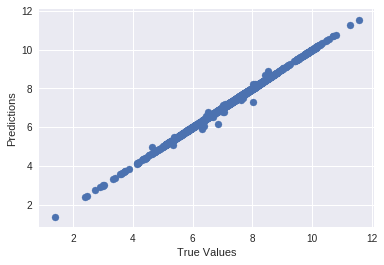

In [95]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions') 




## 2da PARTE

In [0]:
#dfSample = dfCompleto.sample(10)

In [0]:
# create training and testing vars


In [0]:

#from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
#model_bic = LassoLarsIC(criterion='bic')
#model_bic.fit(matriz.toarray(), precios)
#alpha_bic_ = model_bic.alpha_

#model_aic = LassoLarsIC(criterion='aic')
#model_aic.fit(matriz.toarray(),precios)
#alpha_aic_ = model_aic.alpha_

#display(alpha_bic_,alpha_aic_)

# Tengo x e y
# Vamos jugando con los modelos

In [98]:
predictions[0:5]

array([7.65333677, 6.59896306, 6.55979681, 7.9407656 , 6.47850964])

In [0]:
## The line / model


In [99]:
print ('Score:', model.score(X_test, y_test))

Score: 0.9993974616189171


In [100]:
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=6) # Define the split - into 2 folds 
kf.get_n_splits(df) # returns the number of splitting iterations in the cross-validator

6

In [0]:
#for train_index, test_index in kf.split(df):
#    print('Train', train_index, 'Test', test_index)
#    X_train, X_test = df[train_index], df[test_index]
#    y_train, y_test = y[train_index], y[test_index]


In [101]:
# Necessary imports: 
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [102]:

# Perform 6-fold cross validation
scores = cross_val_score(model, fullDF, y, cv=6)
print ('Cross-validated scores:', scores)

Cross-validated scores: [0.99986459 0.99809806 0.99990093 0.99721631 0.99993291 0.99978181]


In [0]:
# Make cross validated predictions
predictions = cross_val_predict(model, fullDF, y, cv=6)
plt.scatter(y, predictions)

In [360]:
accuracy = metrics.r2_score(y, predictions)
print (accuracy)

0.999491380372486


# 3. Comparación Modelos

In [0]:
# Importamos librerías

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold # import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [0]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada

al_ridge = np.linspace(0.001, 20, 10)
al_lasso = np.linspace(0.1, 10, 10)
kf = KFold(n_splits=6, shuffle=True, random_state=12)

# Instanciamos los modelos

lm = LinearRegression(fit_intercept=True,normalize=True)
lmRidgeCV = RidgeCV(alphas=al_ridge, cv=kf, normalize=False)
lmLassoCV = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

## 3.1 Regresión lineal

In [364]:
# Entrenamos el modelo LM

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
print ('Score:', model.score(X_test, y_test))

Score: 0.9999922279544402


In [0]:
# Hacemos cross validation

scores = cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2') 
scores, scores.mean()

(array([0.2144315 , 0.21555728, 0.21875726, 0.21812945, 0.21408121,
        0.21896367]), 0.21665339405160414)

## 3.2 Modelo Ridge

In [365]:
# Entrenamos el modelo Ridge

ridgemodel = lmRidgeCV.fit(X_train, y_train)
ridgemodel.score

<bound method RegressorMixin.score of RidgeCV(alphas=array([1.00000e-03, 2.22311e+00, 4.44522e+00, 6.66733e+00, 8.88944e+00,
       1.11116e+01, 1.33337e+01, 1.55558e+01, 1.77779e+01, 2.00000e+01]),
    cv=KFold(n_splits=6, random_state=12, shuffle=True),
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)>

In [0]:
#Hacemos cross validation

scores = cross_val_score(ridgemodel, X_train, y_train, cv=kf, scoring='r2')
dict(alpha=ridgemodel.alpha_, scores=scores, mean_score=scores.mean())

In [0]:
print ("r^2:", ridgemodel.score(X_test, y_test))
print ("alpha:", ridgemodel.alpha_)

r^2: 0.2749794842700505
alpha: 15.555777777777775


## 3.3 Modelo Lasso

In [0]:
# Entrenamos el modelo Lasso

lassomodel = lmLassoCV.fit(X_train, y_train)

In [0]:
#Hacemos cross validation

scores = cross_val_score(lassomomodel, X_train, y_train, cv=kf, scoring='r2')
dict(alpha=lassomodel.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 0.1,
 'mean_score': 0.039844735076225324,
 'scores': array([0.0447771 , 0.03688315, 0.0449976 , 0.03764962, 0.03286014,
        0.04190081]),
 'zero_coefs': 222}

In [0]:
print ("r^2:", lassomodel.score(X_test, y_test))
print ("alpha:", lassomodel.alpha_)

r^2: 0.04273292504536353
alpha: 0.1


## 3.4 ElasticNet

In [0]:
elasticnet_model = linear_model.ElasticNet()

# Ajustamos nuevamente, esta vez con regularizacion

elasticnet_model = elasticnet_model.fit(X_train, y_train)
predictions = elasticnet_model.predict(X_test)

print ("r^2:", elasticnet_model.score(X_test, y_test))

r^2: -0.0004189215404966085


## 3.5 Graficación Alphas

In [0]:
# Usando Gridsearch para encontrar los parámetros